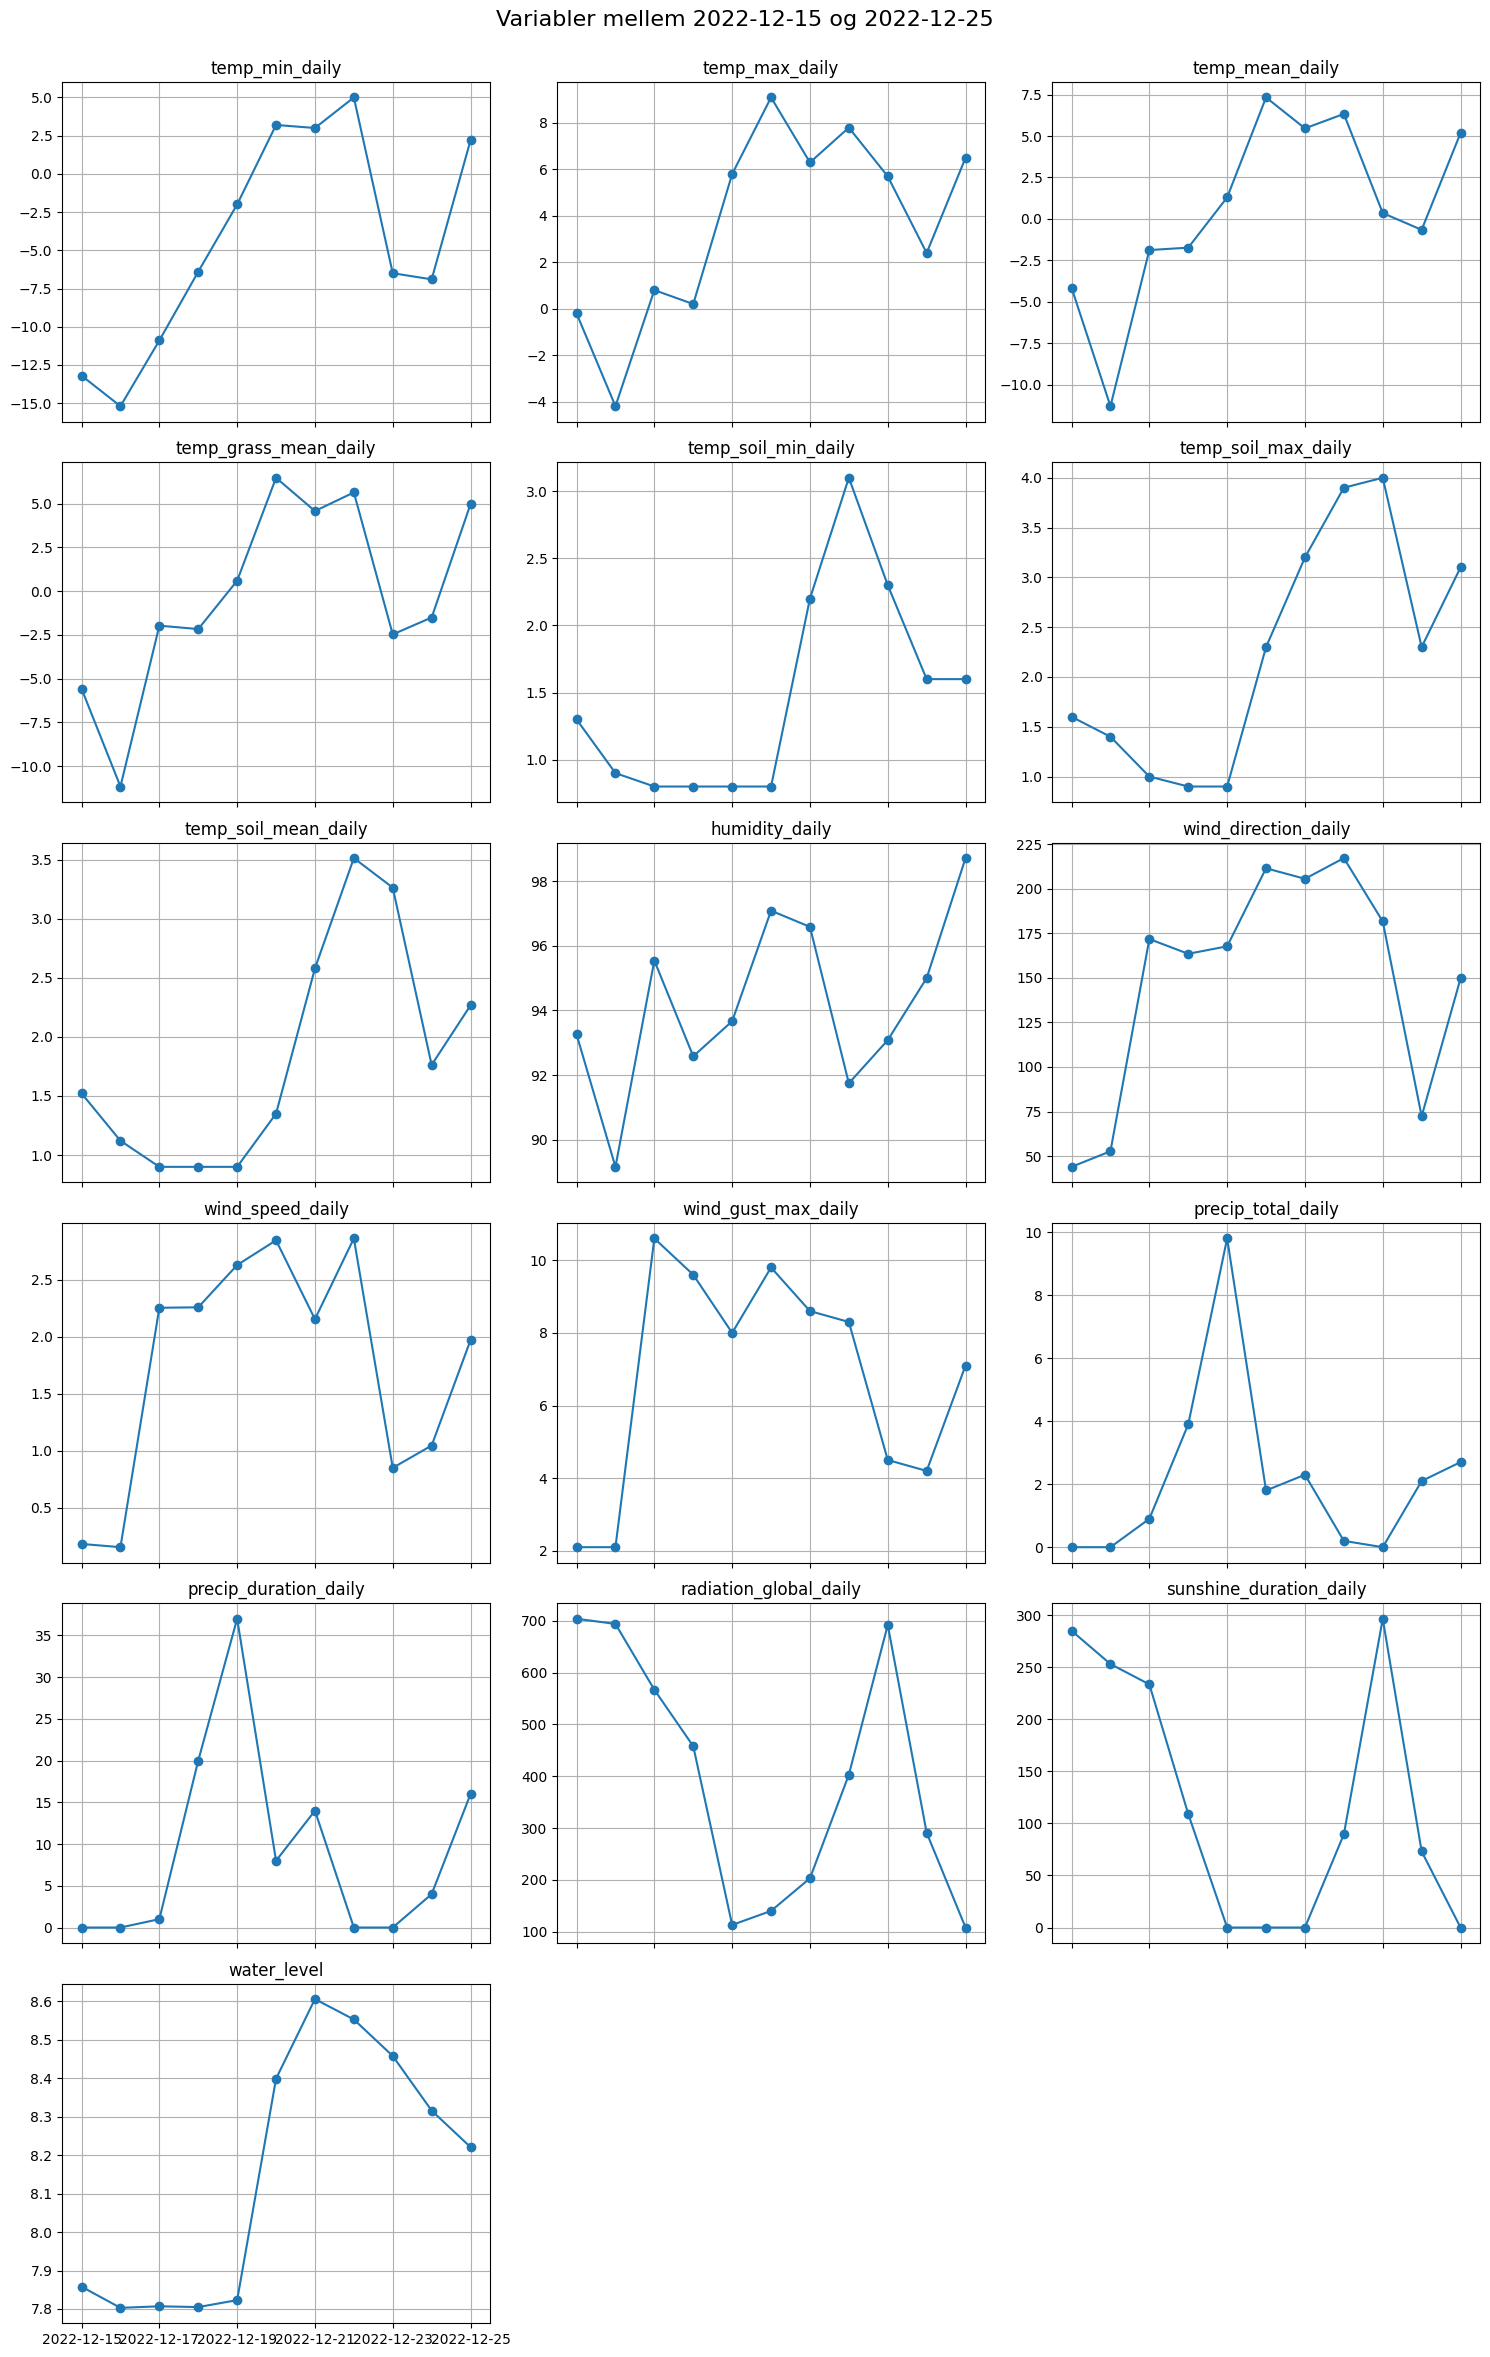

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Paths (brug de samme stier som i dit oprindelige script)
DATA_PATH          = '/Users/nicolaigarderhansen/Desktop/Bachelorprojekt/Forecasting-water-inflow/Data loading and handling/Cleaned data etc./data_cleaned_and_interpolated.csv'
VANDSTAND_PATH     = '/Users/nicolaigarderhansen/Desktop/Bachelorprojekt/Forecasting-water-inflow/Data loading and handling/Raw data/28.02_Vandstand (DMP)_Dag.csv'

# Config
date_col   = 'time'
target_col = 'KarupBro'
input_cols = [
    'temp_min_daily', 'temp_max_daily', 'temp_mean_daily', 
    'temp_grass_mean_daily', 'temp_soil_min_daily', 'temp_soil_max_daily', 
    'temp_soil_mean_daily', 'humidity_daily', 'wind_direction_daily', 
    'wind_speed_daily', 'wind_gust_max_daily', 'precip_total_daily', 
    'precip_duration_daily', 'radiation_global_daily', 
    'sunshine_duration_daily'
]

# 1) Load cleaned & interpolated data
df = pd.read_csv(DATA_PATH, parse_dates=[date_col])
df.sort_values(date_col, inplace=True)
df.set_index(date_col, inplace=True)

# 2) Funktion til at loade daglige vandstandstal
def load_daily_vandstand(path):
    # Find header‐linjen ("Dato (DK normaltid)...")
    with open(path, encoding='latin1') as f:
        for i, line in enumerate(f):
            if line.strip().startswith('Dato (DK normaltid)'):
                header_row = i
                break

    # Læs kun dato og vandstandskolonner
    vand = pd.read_csv(
        path,
        sep=';',
        skiprows=header_row,
        header=0,
        usecols=[0, 1],
        encoding='latin1',
        engine='python'
    )
    # Omdøb og parse dato
    vand.columns = ['date', 'water_level']
    vand['date'] = pd.to_datetime(vand['date'], dayfirst=True)
    vand.set_index('date', inplace=True)
    return vand

# 3) Load og merge vandstand
vand_df = load_daily_vandstand(VANDSTAND_PATH)
df = df.join(vand_df['water_level'], how='left')

# --- Her starter det nye: filter og plot mellem 2022-12-15 og 2022-12-25 ---

# 4) Filtrer tidsrække
start, end = '2022-12-15', '2022-12-25'
df_subset = df.loc[start:end]

# 5) Plot alle kolonner i én figur med underplots
all_columns = input_cols + ['water_level']
n = len(all_columns)

# Vælg en layout (fx 6 rækker x 3 kolonner = plads til op til 18 plots)
ncols = 3
nrows = int(np.ceil(n / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 4*nrows), sharex=True)
axes = axes.flatten()

for i, col in enumerate(all_columns):
    axes[i].plot(df_subset.index, df_subset[col], marker='o', linestyle='-')
    axes[i].set_title(col)
    axes[i].grid(True)

# Hvis der er nogle akser tilbage uden data (fordi n < nrows*ncols), fjern dem
for j in range(n, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.subplots_adjust(top=0.95)
fig.suptitle(f'Variabler mellem {start} og {end}', fontsize=16)
plt.show()